# Comparing Classifiers for Building Classification Models

Chanin Nantasenamat

<i>Data Professor YouTube channel, http://youtube.com/dataprofessor </i>

In this Jupyter notebook, we will be comparing the performance of different classifiers for building classification models.

## 1. Make synthetic dataset

### 1.1. Import library

In [24]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/data-task1'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.


In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential

from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

# Description of the Pneumonia Dataset
**The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).
Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.
For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.**

In [26]:
labels = ['pneumonia', 'no_pneumonia']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir,label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

# Loading the Dataset (has already been split into separate folders)

In [27]:
datadir = os.getcwd()
train = get_training_data('C:/Users/Computing/Downloads/data-task1/train/')
test = get_training_data('C:/Users/Computing/Downloads/data-task1/test/')
val = get_training_data('C:/Users/Computing/Downloads/data-task1/val/')

C:\Users\Computing\AppData\Local\Temp\ipykernel_8876\3388793708.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


# Data Visualization & Preprocessing

C:\Users\Computing\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

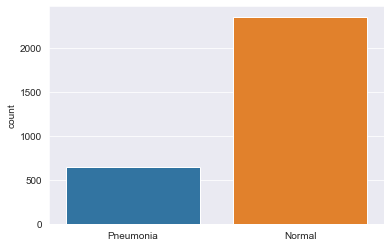

In [28]:
l = []
test_labels = []
for i in train:
    if(i[1] == 0):
        label = 0
        l.append("Pneumonia")
    else:
        label = 1
        l.append("Normal")
    test_labels.append(label)
test_labels = np.array(test_labels)
sns.set_style('darkgrid')
sns.countplot(l)   


**The data seems imbalanced . To increase the no. of training examples, we will use data augmentation**

**Previewing the images of both the classes**

Text(0.5, 1.0, 'no_pneumonia')

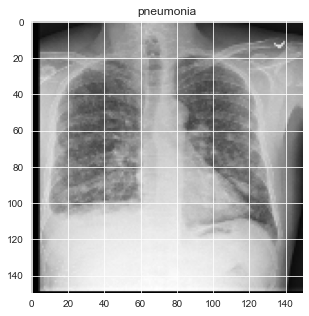

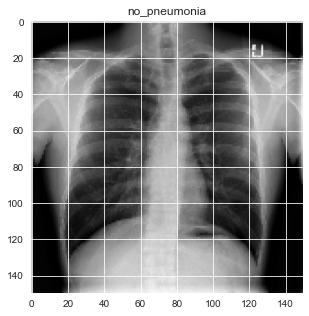

In [29]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

### 1.2. Generate the dataset

In [30]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

**We perform a grayscale normalization to reduce the effect of illumination's differences.Moreover the CNN converges faster on [0..1] data than on [0..255].**

In [40]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

(3000, 150, 150)

In [41]:
# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

(3000, 150, 150, 1)

# Data Augmentation
**In order to avoid overfitting problem, we need to expand artificially our dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations.
Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more.
By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.**

In [ ]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

### 1.3. Let's examine the data dimension

In [ ]:
x_train.shape

(3000, 150, 150, 1)

In [ ]:
x_test.shape

(500, 150, 150, 1)

In [ ]:
x_train.shape, y_train.shape

((3000, 150, 150, 1), (3000,))

In [ ]:
x_test.shape, y_test.shape

((500, 150, 150, 1), (500,))

## 3. Build Classification Models

Modified from: https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

### 3.1. Import modules

In [ ]:
import pandas as pd

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import SGDClassifier

## Train models

In [ ]:
#https://www.pluralsight.com/guides/introduction-to-densenet-with-tensorflow


### 3.2. Defining learning classifiers

In [ ]:
names = ["Nearest_Neighbors", "Linear_SVM", "Polynomial_SVM", "RBF_SVM", "Gaussian_Process",
         "Gradient_Boosting", "Decision_Tree", "Extra_Trees", "Random_Forest", "Neural_Net", "AdaBoost",
         "Naive_Bayes", "QDA", "SGD"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(kernel="poly", degree=3, C=0.025),
    SVC(kernel="rbf", C=1, gamma=2),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    GradientBoostingClassifier(n_estimators=100, learning_rate=1.0),
    DecisionTreeClassifier(max_depth=5),
    ExtraTreesClassifier(n_estimators=10, min_samples_split=2),
    RandomForestClassifier(max_depth=5, n_estimators=100),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(n_estimators=100),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    SGDClassifier(loss="hinge", penalty="l2")]

### 3.3. Build Model, Apply Model on Test Data & Record Accuracy Scores

In [ ]:
scores = []
for name, clf in zip(names, classifiers):
    history = clf.fit(datagen.flow(x_train,y_train, batch_size = 32), datagen.flow(x_val, y_val))
    score = clf.score(x_test, y_test)
    scores.append(score)

MemoryError: Unable to allocate 2.75 MiB for an array with shape (32, 150, 150, 1) and data type float32

In [ ]:
scores

## 4. Analysis of Model Performance

### 4.1. Import library

In [ ]:
import pandas as pd
import seaborn as sns

### 4.2. Create data frame of *model performance*

In [ ]:
df = pd.DataFrame()
df['name'] = names
df['score'] = scores
df

### 4.3. Adding colors to the data frame

In [ ]:
#https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html

cm = sns.light_palette("green", as_cmap=True)
s = df.style.background_gradient(cmap=cm)
s

### 4.4. Bar plot of model performance

In [ ]:
sns.set(style="whitegrid")
ax = sns.barplot(y="name", x="score", data=df)

---